**<h1>Importing Librares**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression


**<h1>Importing Data set**

In [ ]:
df = pd.read_csv('Updated_for_machine_learnig_Loan.csv')


**<h1>Spliting the data into training and testing sets**

In [ ]:
X = df.drop(columns=['LoanApproved', 'RiskScore'])
y = df['RiskScore']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**<h2>Cleaning test and train data**

In [ ]:
X_train_cleaned = X_train.drop(columns=['ApplicationDate'])
X_test_cleaned = X_test.drop(columns=['ApplicationDate'])

**<h1>Initialize the XGBoost Model**

In [ ]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

**<h1>Dimensionality Reduction**

In [ ]:
rfe = RFE(estimator=xgb_model, n_features_to_select=10)
rfe.fit(X_train_cleaned, y_train)

RFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, device=None,
                           early_stopping_rounds=None, enable_categorical=False,
                           eval_metric=None, feature_types=None, gamma=None,
                           grow_policy=None, importance_type=None,
                           interaction_constraints=None, learning_rate=None,
                           max_bin=None, max_cat_threshold=None,
                           max_cat_to_onehot=None, max_delta_step=None,
                           max_depth=None, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, multi_strategy=None,
                           n_estimators=None, n_jobs=None,
                           num_parallel_tree=None, random_state=42, ...),
    n_features_to_select=10)

**<h1>Check which features were selected**

In [ ]:
selected_features = X_train_cleaned.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['CreditScore', 'EmploymentStatus', 'EducationLevel', 'LoanDuration',
       'BankruptcyHistory', 'PreviousLoanDefaults', 'LengthOfCreditHistory',
       'TotalAssets', 'BaseInterestRate', 'TotalDebtToIncomeRatio'],
      dtype='object')


**<h1> Filter training and testing data with selected features**

In [ ]:
X_train_selected = X_train_cleaned[selected_features]
X_test_selected = X_test_cleaned[selected_features]


**<h1>Train the Model**

**<h2>Model Comparison**

In [ ]:
from sklearn.ensemble import StackingRegressor
models = {
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'Linear Regression': LinearRegression()
}
model_performance = {}
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = mse ** 0.5
    model_performance[name] = {
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'RMSE': rmse
    }
for name, metrics in model_performance.items():
    print(f"Model: {name}")
    print(f"MSE: {metrics['MSE']:.4f}, MAE: {metrics['MAE']:.4f}, R²: {metrics['R²']:.4f}, RMSE: {metrics['RMSE']:.4f}")
    print("-" * 50)


Model: XGBoost
MSE: 0.3178, MAE: 0.4423, R²: 0.6685, RMSE: 0.5637
--------------------------------------------------
Model: Random Forest
MSE: 0.3121, MAE: 0.4349, R²: 0.6745, RMSE: 0.5587
--------------------------------------------------
Model: SVR
MSE: 0.3074, MAE: 0.4423, R²: 0.6793, RMSE: 0.5545
--------------------------------------------------
Model: Linear Regression
MSE: 0.4349, MAE: 0.5376, R²: 0.5464, RMSE: 0.6595
--------------------------------------------------


**<h1>Hyperparameter Tuning**

In [ ]:

param_dist = {
    'C': np.logspace(-1, 1, 3),  # Narrowing the range of C
    'kernel': ['rbf'],
    'gamma': ['scale'],
    'epsilon': [0.1]
}

random_search = RandomizedSearchCV(SVR(), param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search.fit(X_train_selected, y_train)
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_svr_model = random_search.best_estimator_



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.1, 'C': 10.0}


In [ ]:
y_pred_best_svr = best_svr_model.predict(X_test_selected)
mse_best_svr = mean_squared_error(y_test, y_pred_best_svr)
mae_best_svr = mean_absolute_error(y_test, y_pred_best_svr)
r2_best_svr = r2_score(y_test, y_pred_best_svr)
rmse_best_svr = np.sqrt(mse_best_svr)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 0.43489185961443405
Mean Absolute Error (MAE): 0.5375622074129834
R² Score: 0.5463892548114702
Root Mean Squared Error (RMSE): 0.6594633118031921


**<h1>StandardScaler**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

**<h1>Stacking Regressor**

In [ ]:
from sklearn.ensemble import StackingRegressor

base_learners = [
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42)),
    ('rf', RandomForestRegressor(random_state=42)),
    ('svr', SVR())
]
meta_learner = LinearRegression()
stacking_regressor = StackingRegressor(estimators=base_learners, final_estimator=meta_learner)
stacking_regressor.fit(X_train_scaled, y_train)


StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...e,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('rf', RandomForestRegressor(random_state=42)),
                              ('svr', SVR())],
                  final_estimator=LinearRegression())

**<h1>Performace evalution**

In [ ]:
y_pred_stacking = stacking_regressor.predict(X_test_scaled)
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
mae_stacking = mean_absolute_error(y_test, y_pred_stacking)
r2_stacking = r2_score(y_test, y_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)

print("Stacking Regressor Performance:")
print(f"MSE: {mse_stacking:.4f}")
print(f"MAE: {mae_stacking:.4f}")
print(f"R²: {r2_stacking:.4f}")
print(f"RMSE: {rmse_stacking:.4f}")


Stacking Regressor Performance:
MSE: 0.2868
MAE: 0.4222
R²: 0.7009
RMSE: 0.5355


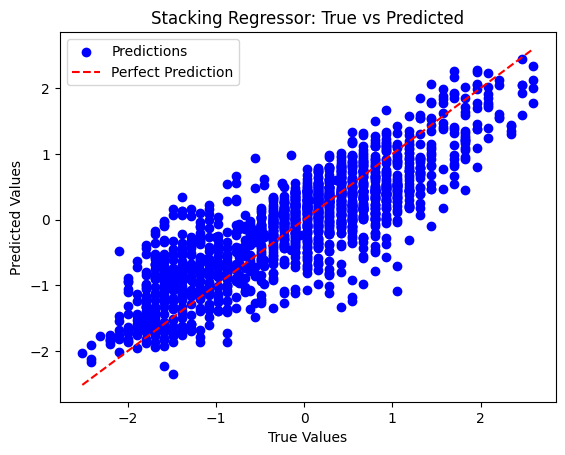

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_stacking, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Stacking Regressor: True vs Predicted")
plt.legend()
plt.show()
